In [1]:
# packages
import pandas as pd
import numpy as np

from claspy.segmentation import BinaryClaSPSegmentation

import ruptures as rpt

import stumpy
from aeon.segmentation import find_dominant_window_sizes

from aeon.segmentation import GreedyGaussianSegmenter

from aeon.segmentation import InformationGainSegmenter

from aeon.anomaly_detection import STRAY

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, make_scorer,mean_squared_error
from ruptures.metrics import precision_recall
import matplotlib.pyplot as plt
#from aeon.visualisation import plot_series_with_change_points, plot_series_with_profiles
import seaborn as sns

sns.set_theme()
sns.set_color_codes()

from claspy.tests.evaluation import f_measure,covering

from claspy.window_size import dominant_fourier_frequency, highest_autocorrelation, suss

C:\Users\tikyn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\aeon\base\__init__.py:24: FutureWarning: The aeon package will soon be releasing v1.0.0 with the removal of legacy modules and interfaces such as BaseTransformer and BaseForecaster. This will contain breaking changes. See aeon-toolkit.org for more information. Set aeon.AEON_DEPRECATION_WARNING or the AEON_DEPRECATION_WARNING environmental variable to 'False' to disable this warning.
  warnings.warn(


In [2]:
def f1scoremargin(ground_truth, predictions, tolerance):
    """
    Calcola l'F1 score con una finestra di tolleranza sui change points.
    
    :param ground_truth: Lista o array di change points reali
    :param predictions: Lista o array di change points predetti
    :param tolerance: La tolleranza temporale (numero di unità temporali)
    :return: precision, recall, f1-score
    """
    ground_truth = np.array(ground_truth)
    predictions = np.array(predictions)
    
    # Vettori per tracciare quali punti sono stati già associati
    matched_ground_truth = np.zeros(len(ground_truth), dtype=bool)
    matched_predictions = np.zeros(len(predictions), dtype=bool)

    mgt={key: False for key in ground_truth}
    mcp={key: False for key in predictions}
    print(f'gt:{len(ground_truth)} - cp:{len(predictions)}')
    # True Positives (TP)
    tp = 0
    for i, gt_point in enumerate(ground_truth):
        for j, pred_point in enumerate(predictions):
            if not matched_predictions[j] and abs(gt_point - pred_point) <= tolerance:
                tp += 1
                matched_ground_truth[i] = True
                matched_predictions[j] = True

                mgt[gt_point] = True
                mcp[pred_point] = True
                break
            
    
    # False Positives (FP) - predizioni non corrispondenti a nessun ground truth entro la tolleranza
    fp = np.sum(~matched_predictions)
    
    # False Negatives (FN) - punti del ground truth non corrispondenti a nessuna predizione entro la tolleranza
    fn = np.sum(~matched_ground_truth)
    #print(f'tp:{tp} - fp:{fp} - fn:{fn}')
    #print(mgt)
    #print(mcp)
    # Calcolo di precision, recall e F1-score
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1

In [3]:
# Questi sono tutte le features estratte
# kineticglobal,kineticchest,directnesshead,density,leftwristke,rightwristke,leftankleke,rightankleke,headke,posturaltension

# Queste sono le feature che utilizzeremo
# kineticglobal, density, leftwirstke, rightwristke, leftankleke, rightankleke, headke, posturaltension
# che corrispondono
# 2,4,5,6,7,8,9,10,11
# Questa funzione legge il file di input e restituisce un dataframe con i dati preprocessati
def ReadAndPreProcess(inputDataRaw):
    # lettura
    df=pd.read_csv(inputDataRaw,sep=' ', header=None)
    df.drop(0, axis=1)
    df["som"]=df.sum(axis=1)
    ## preprocessing

    # dealing NaN values
    #-serafino ha usato forward fill, backward fill, linear interpolation
    #-ricordo che serafino aveva gia utilizzato sta cosa sui dati grezzi non sulle feature ma sui dati prefeature percio dovrebbe essere gia apposto

    # downsampling
    #-sono a 100ms, non sò se devo scendere a 50ms. da decidere
    #-non lo faccio xk non mi interessa se va piu lento, guarda su notion per ulteriori informazioni

    # low pass filter
    #-Skogstad and colleagues (2013) e https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units
    #-implementare dopo

    # remove outliers
    #-utilizzare hampel filter

    # stretch
    #-forse devo stretcharlo come ho fatto precedentemente
    #-anche se nel codice precedente ho stretchato solo il groundtruth

    # ritorno un oggetto dataframe dopo che è stato lavorato, ottenendo un prodotto lavorato
    return df


In [4]:
# questa funzione ritorna un dataframe del groundtruth che viene usato specificatamente per visualizzare il gt
# è soggetto a un preprocessing dei dati siccome l'ultimo groundtruth è dove termina il ts del gt
# di conseguenza per farlo corrispondere, bisogna stretcharlo
# ma ricordo di aver rifatti i dati nuovi per generare un groundtruth a fine ts, da controllare cosi che non serve stretcharlo?
def LoadingGroundTruth(df,gtraw):
    gt=pd.read_csv(gtraw,sep=' ', header=None)
    gt=gt.iloc[:,0].values
    #stretching dei dati se necessario per farlo corrispondere alla ts dei dati
    stretch_gt = np.array([])
    for idx,i in enumerate(gt):
        relpos = len(df)*i/gt[-1]
        stretch_gt = np.append(stretch_gt,relpos)

    # eliminiamo l'ultimo elemento che è stato annotato solo per delimitare la lunghezza della gt simile alla ts
    return stretch_gt[:-1]

In [5]:
def test(test, **kwargs):
    return BinaryClaSPSegmentation(**kwargs)

asd=test("asd",window_size="fft",distance="euclidean_distance")
print(asd.window_size)
print(asd.distance)

fft
euclidean_distance


In [6]:
# utilizzo CLASP 
# prende come parametro un dataframe e restituisce il clasp score
# gt e known vengono usati per usare il numero vero di cp se uguale a 1 sennò si cerca di predirlo se il modello lo permette
def GetClasp(df,gt,known, **kwargs):
    
    result=np.array([])
    eachresult = []
    eachclasp=[]
    for idx,i in enumerate([2,4,5,6,7,8,9,10]):#,11]):
    
        ts=df.iloc[:,i]
        
        #print(ts.head())
        if known == 1:
            print("knwon!")
            clasp = BinaryClaSPSegmentation(n_segments=len(gt), validation=None)
        else:
            print("unknown!")
            clasp = BinaryClaSPSegmentation(**kwargs)
            
        found_cps = clasp.fit_predict(ts.values)    

        # c'è un bug con binseg dove un cp è oltre la lunghezza del ts
        # faccio un loop e se eccede cambio il valore con la len(tf)-1
        for i in range(0,len(found_cps)):
            if found_cps[i] >= len(ts):
                found_cps[i] = len(ts)-1

        # per ogni array di cp di ogni singola feature
        # li unisco in un unico array. in pratica faccio un OR di tutti i cp
        result = np.sort(np.append(result,found_cps).flatten())
        result = np.unique(result)
        eachresult.append(found_cps)
        eachclasp.append(clasp)
        
        

        
    return result, eachresult, eachclasp
        
    


In [46]:
def PlotResult(df,gt,cp, nomeFile, margin,clasplist):
    #da testare quando ho piu valori
    #clasp.plot(gt_cps=gt.astype(int), heading="Segmentation of different umpire cricket signals", ts_name="ACC", file_path="segmentation_example.png")

    plt.figure(figsize=(18,9))
    plt.plot(np.arange(len(df["som"].values)),df["som"].values,'blue',linewidth=0.5)

    for i in gt.astype(int):
     
        plt.axvline(x = i, color = 'green',linewidth=1) 
            
    for j in cp.tolist():
        plt.axvline(x = j, color = 'red',linewidth=1,linestyle="-.") 

    for k in gt.astype(int):
        plt.fill_betweenx(np.array([0, 1]), k-margin, k+margin, color='green', alpha=0.3)
    plt.xlabel(f'{nomeFile} {f1scoremargin(gt.astype(int),cp.astype(int),margin)}')

    plt.figure(figsize=(18,9))

    for idx,clasp in enumerate(clasplist):
        
        plt.plot(np.arange(len(clasp.profile)),clasp.profile,"blue",linewidth=0.5, alpha=0.8)



In [47]:
def Plotclasp(eachclasp,gt,margin,eachcp):
    #print("idx"+str(asd))
    
    for idx,clasp in enumerate(eachclasp):
        clasp.plot(gt_cps=gt.astype(int), heading=f'f1margin: {f1scoremargin(gt.astype(int),eachcp[idx].astype(int),margin)}', ts_name="suss")
        #clasp.plot(gt_cps=None, heading=f'f1margin: {f1scoremargin(gt.astype(int),eachcp[idx].astype(int),margin)}', ts_name="suss")


    
        for idx2,j in enumerate(gt.astype(int)):
            plt.fill_betweenx(np.array([0, 1]), j-margin, j+margin, color='green', alpha=0.3)

        


In [48]:
# calcola i vari scores dati il groundtruth e il prediction
# puo salvare il risultato su file per evitare di perderli
# prende come parametro nome del groundtruth, groundtruth, nome della timeseries e il prediction
def Evaluate(modelName,gtName, gt, tsName, cp, df, margin):
    # creo dei array di lunghezza come la ts cosi possono fare il confronto
    # sia per il gt che per il pd
  
    cpnump = np.array(cp)
    gtnump = np.array(gt)

    cp_long = np.zeros(len(df)+1)
    cp_long[cpnump.astype(int)]=1

    gt_long = np.zeros(len(df)+1)
    gt_long[gtnump.astype(int)]=1

    # calcolo lo score 
    print(f'f1margin: {f1scoremargin(gt.astype(int),cp.astype(int),margin)}')
    
    

In [49]:
#questi sono i dataset comprendente le timeseries e il groundtruth
timeseries=[#"in\cora1_input.txt",
      #"in\cora4_input.txt",
      "in\cora1_input.txt",
      "in\cora4_input.txt",
      "in\cora5_input.txt",
      "in\cora14_input.txt",
      "in\cora14_input.txt",
      "in\marianne7_input.txt",
      "in\marianne8_input.txt",
      "in\marianne10_input.txt",
      "in\marianne18_input.txt",
      "in\marianne19_input.txt",
      "in\marianne24_input.txt",
      "in\marianne26_input.txt",
      "in\marianne41_input.txt",
      "in\marianne42_input.txt",
      "in\marianne43_input.txt",
      "in\marianne47_input.txt",
      "in\marianne48_input.txt",
      "in\marianne48_input.txt",
      "in\muriel18_input.txt",
      "in\muriel26_input.txt",
      "in\muriel27_input.txt",
      "in\muriel30_input.txt"
     # "in\muriel30_input.txt"
      ]
groundtruth=[#"gt\cora_gt_2019-08-08_t001_video01.txt",
         #"gt\cora_gt_2019-08-08_t004_video01.txt",
         "gt\cora_gt_2019-08-08_t001_video01.txt",
         "gt\cora_gt_2019-08-08_t004_video01.txt",
         "gt\cora5_gt.txt",
         "gt\cora_gt_2019-08-08_t014_video01.txt",
         "gt\marianne_gt_2016-03-22_t007_video01.txt",
         "gt\marianne_gt_2016-03-22_t008_video01.txt",
         "gt\marianne_gt_2016-03-22_t010_video01.txt",
         "gt\marianne_gt_2016-03-22_t018_video01.txt",
         "gt\marianne_gt_2016-03-22_t019_video01.txt",
         "gt\marianne_gt_2016-03-22_t024_video01.txt",
         "gt\marianne_gt_2016-03-22_t026_video01.txt",
         "gt\marianne_gt_2016-03-22_t041_video01.txt",
         "gt\marianne_gt_2016-03-22_t042_video01.txt",
         "gt\marianne_gt_2016-03-22_t043_video01.txt",
         "gt\marianne_gt_2016-03-22_t047_video01.txt",
         "gt\marianne_gt_2016-03-22_t048_video01.txt",
         "gt\marianne_gt_2016-03-22_t048_video01.txt",
         "gt\muriel_gt_2016-03-21_t014_video01.txt",
         "gt\muriel_gt_2016-03-21_t018_video01.txt",
         "gt\muriel_gt_2016-03-21_t026_video01.txt",
         "gt\muriel_gt_2016-03-21_t027_video01.txt",
         "gt\muriel_gt_2016-03-23_t029_video01.txt",
         "gt\muriel_gt_2016-03-23_t030_video01.txt",
        # "gt\muriel_gt_2016-03-23_t030_video01.txt"
         ]



print(f"FFT: {dominant_fourier_frequency(df.iloc[:,4].values)}")
print(f"ACF: {highest_autocorrelation(df.iloc[:,4].values)}")
print(f"SuSS: {suss(df.iloc[:,4].values)}")

# CLASP without knowing cp
for i in range(0,1):#len(timeseries)):
    df=ReadAndPreProcess(timeseries[i])
    gt=LoadingGroundTruth(df,groundtruth[i])
    cp,eachcp,clasp=GetClasp(df,gt,0, window_size="fft",distance="euclidean_distance",k_neighbours=3,excl_radius=4,n_estimators=50)
    Plotclasp(clasp,gt,100,eachcp)
    Evaluate("CLASP",groundtruth[i],gt,timeseries[i],cp,df,100)

In [50]:
def delnear(arr,range):
    i = 0
    while i < len(arr) - 1:
        # Iniziamo con il primo elemento di un potenziale gruppo
        gruppo_inizio = i
        gruppo_fine = i

        # Cerca gli elementi che fanno parte dello stesso gruppo
        while gruppo_fine < len(arr) - 1 and arr[gruppo_fine + 1] - arr[gruppo_fine] < range:
            gruppo_fine += 1

        # Se esiste un gruppo di più elementi
        if gruppo_fine > gruppo_inizio:
            # Se la distanza tra l'inizio e la fine è minore di 50, elimina l'elemento maggiore (gruppo_fine)
            if arr[gruppo_fine] - arr[gruppo_inizio] < range:
                arr = np.delete(arr, gruppo_fine)
            
            # Elimina tutti gli elementi interni al gruppo
            arr = np.concatenate((arr[:gruppo_inizio + 1], arr[gruppo_fine:]))

        # Procedi con il prossimo gruppo
        i = gruppo_inizio + 1

    return arr

unknown!
unknown!
unknown!
unknown!
unknown!
unknown!
unknown!
unknown!
gt:17 - cp:13
gt:17 - cp:20
gt:17 - cp:17
gt:17 - cp:16
gt:17 - cp:12
gt:17 - cp:12
gt:17 - cp:10
gt:17 - cp:14
gt:17 - cp:41
gt:17 - cp:41
f1margin: (0.3902439024390244, 0.9411764705882353, 0.5517241379310345)


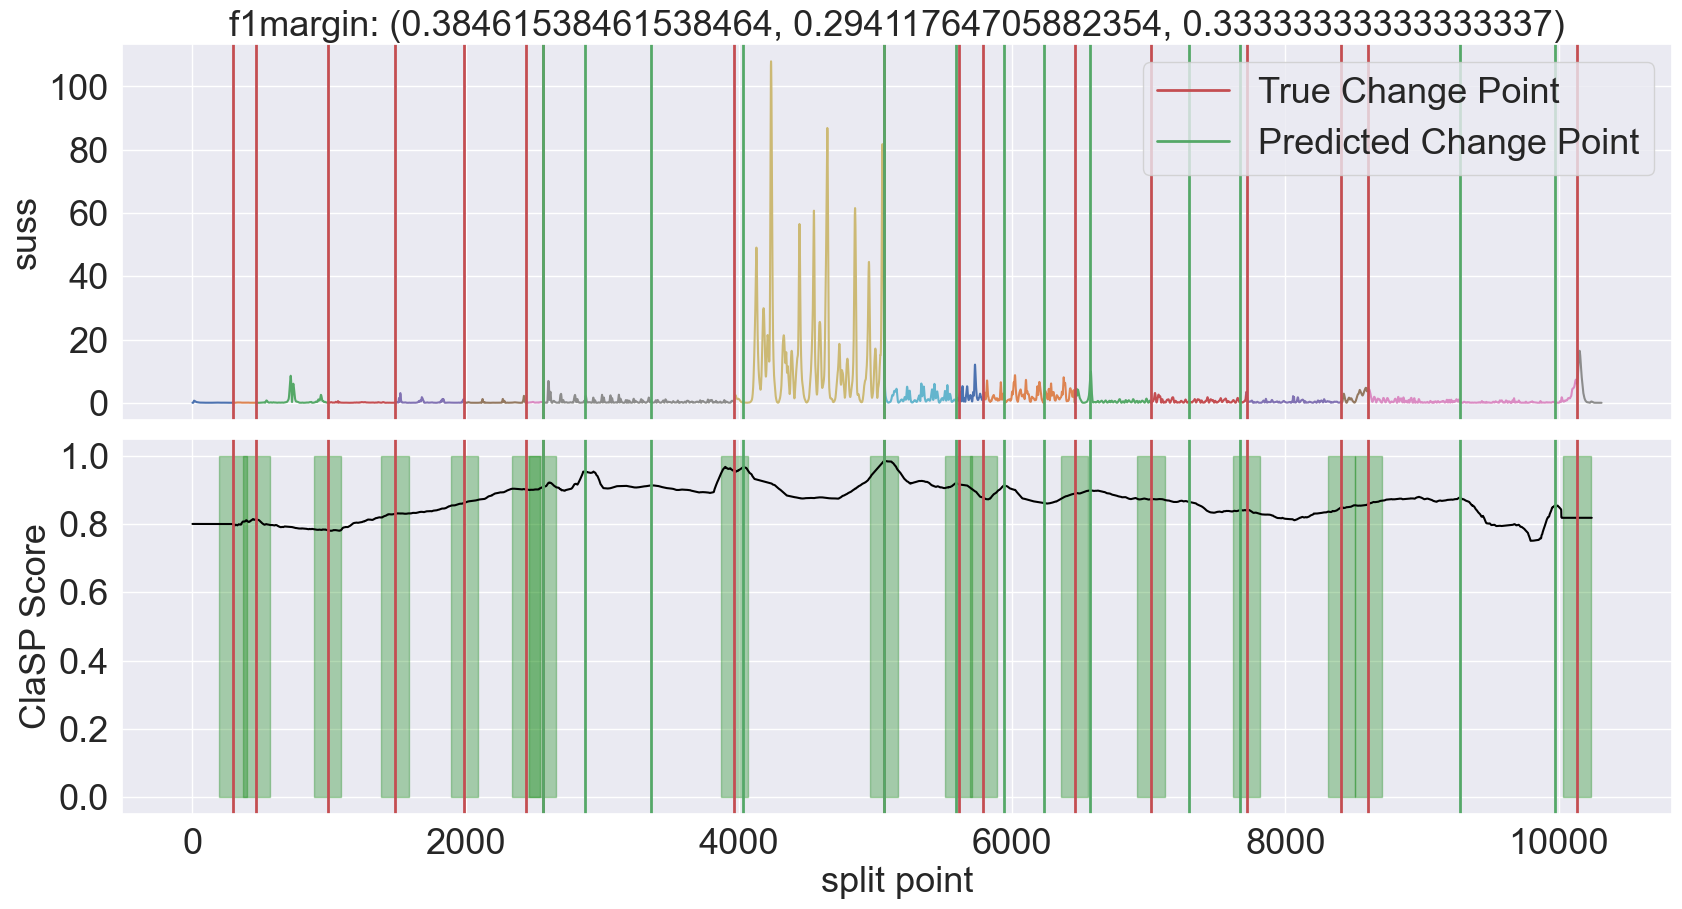

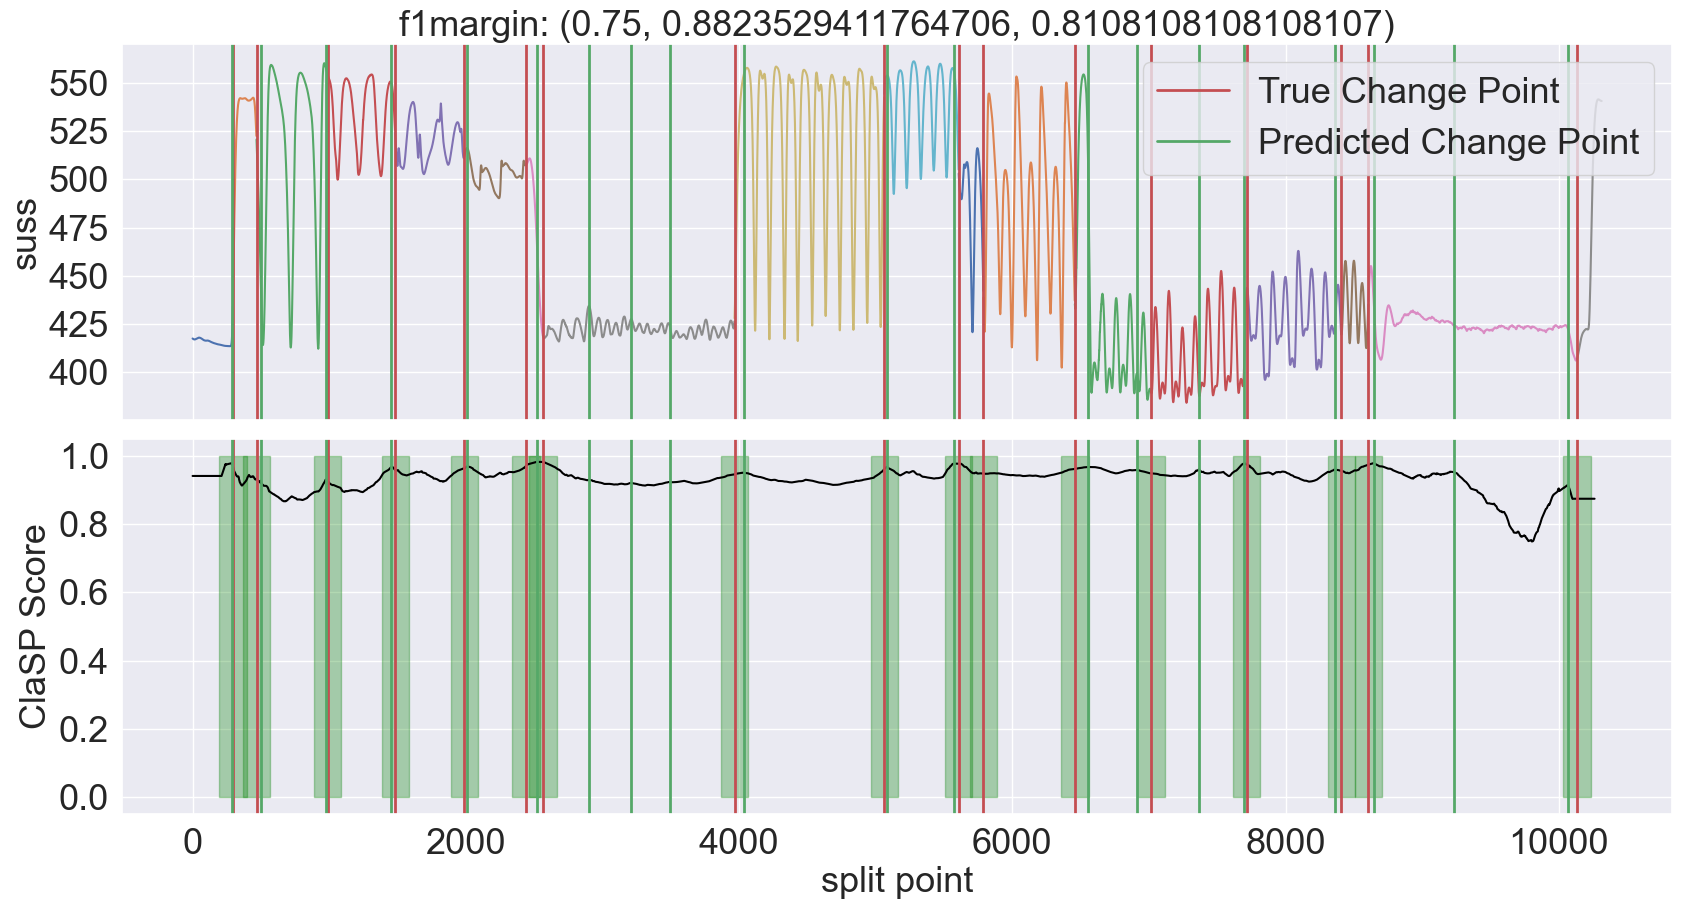

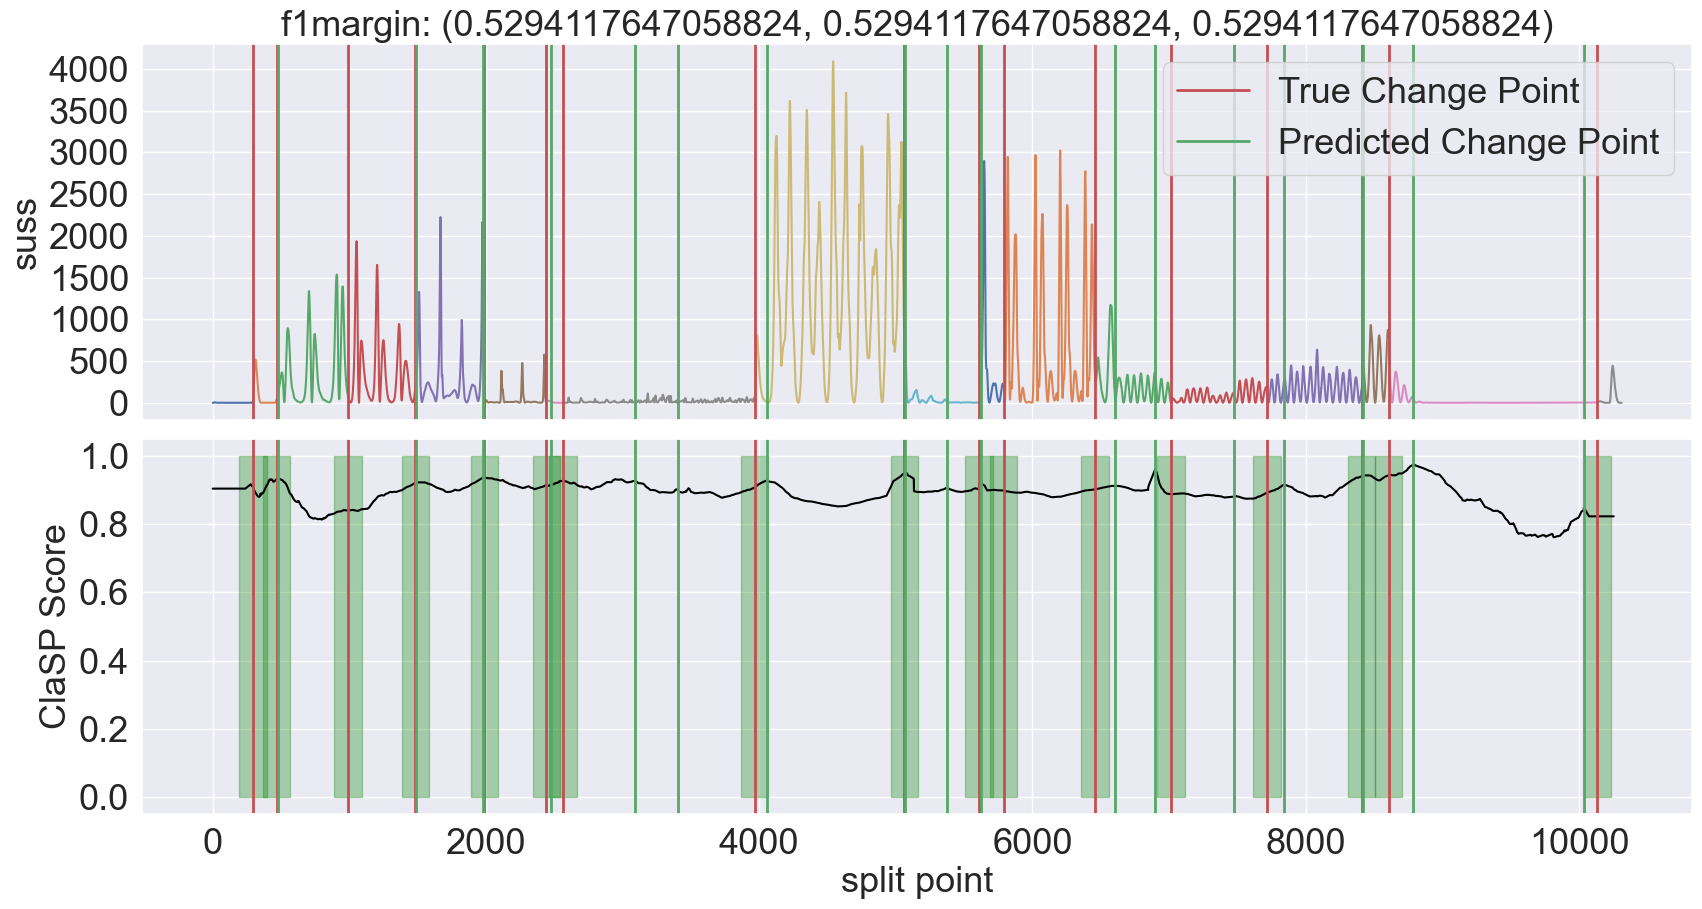

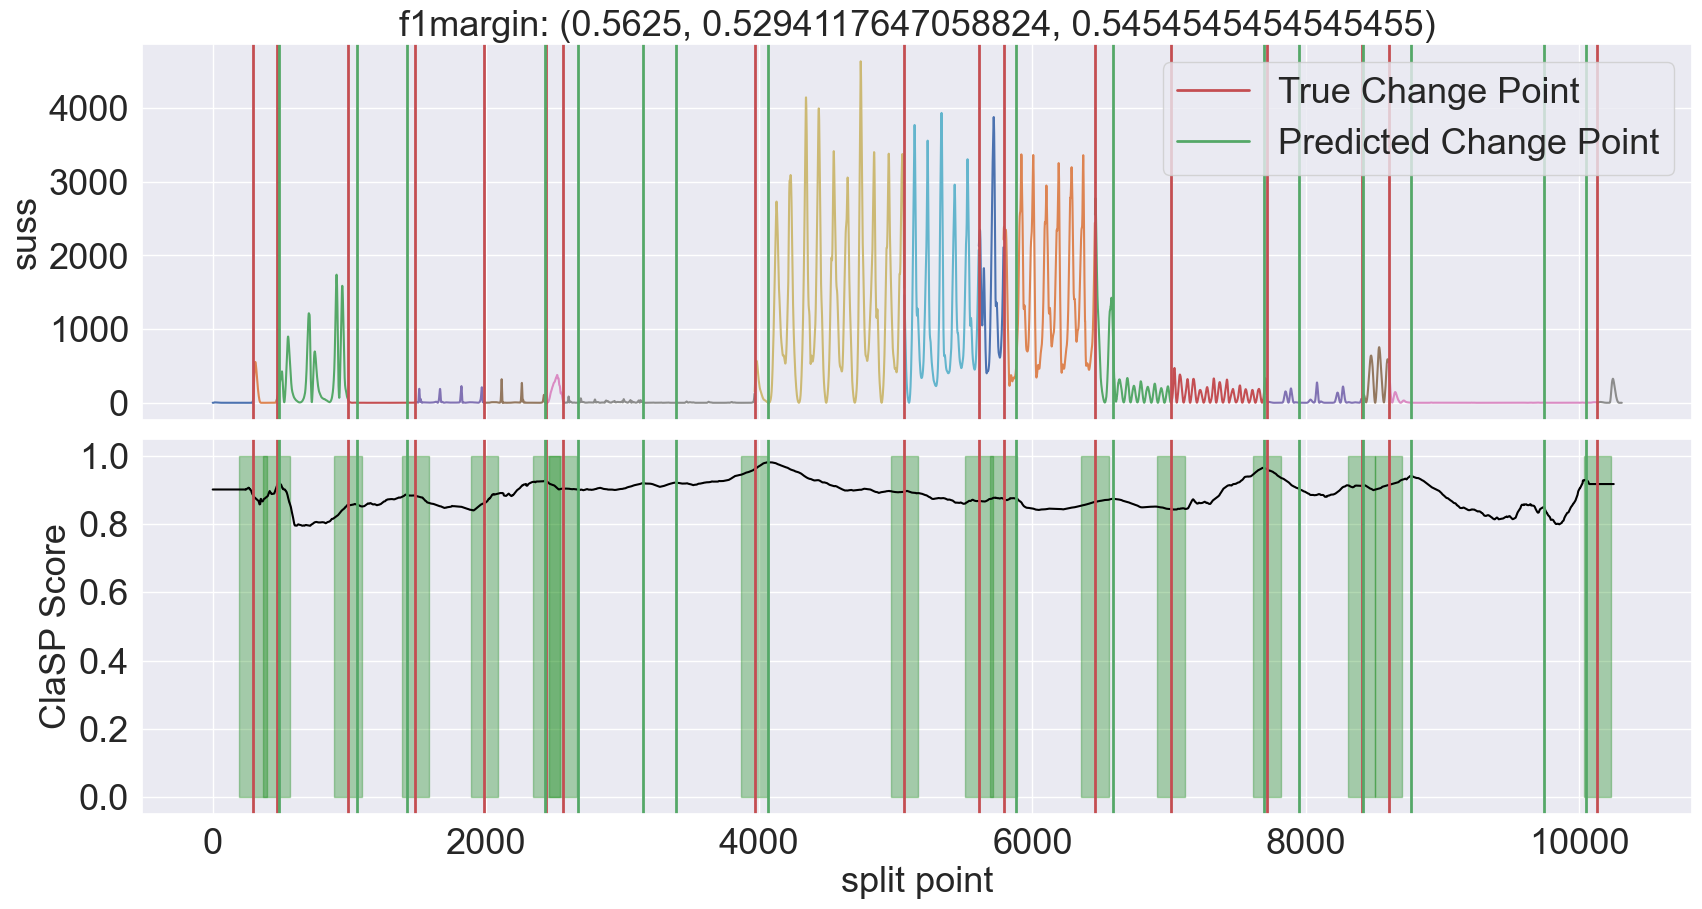

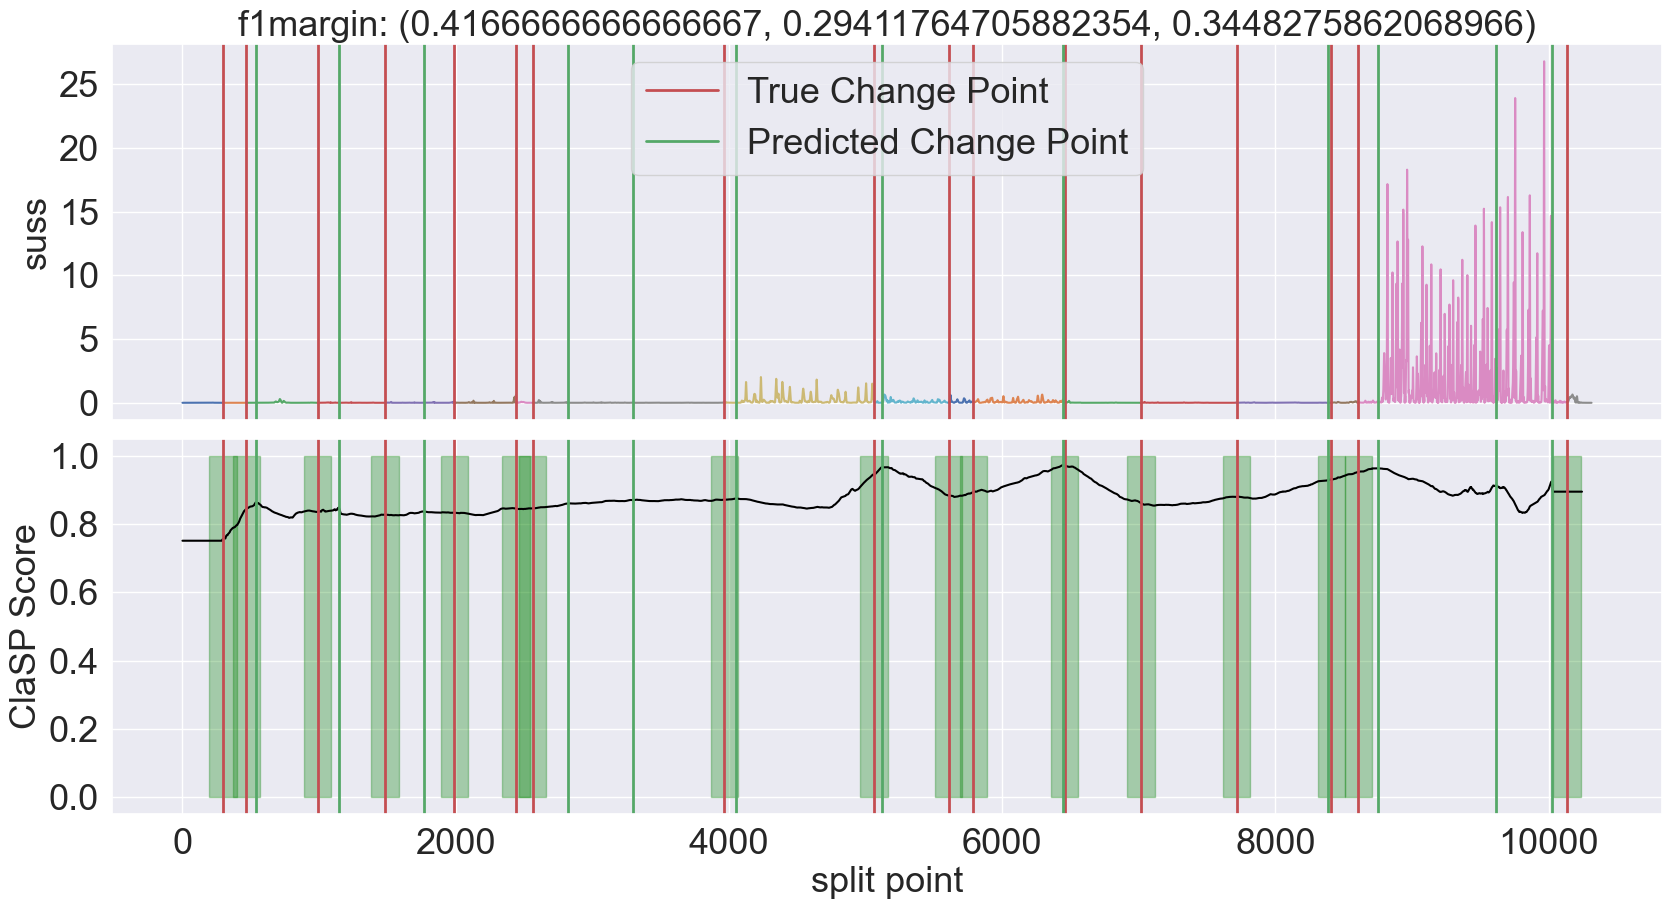

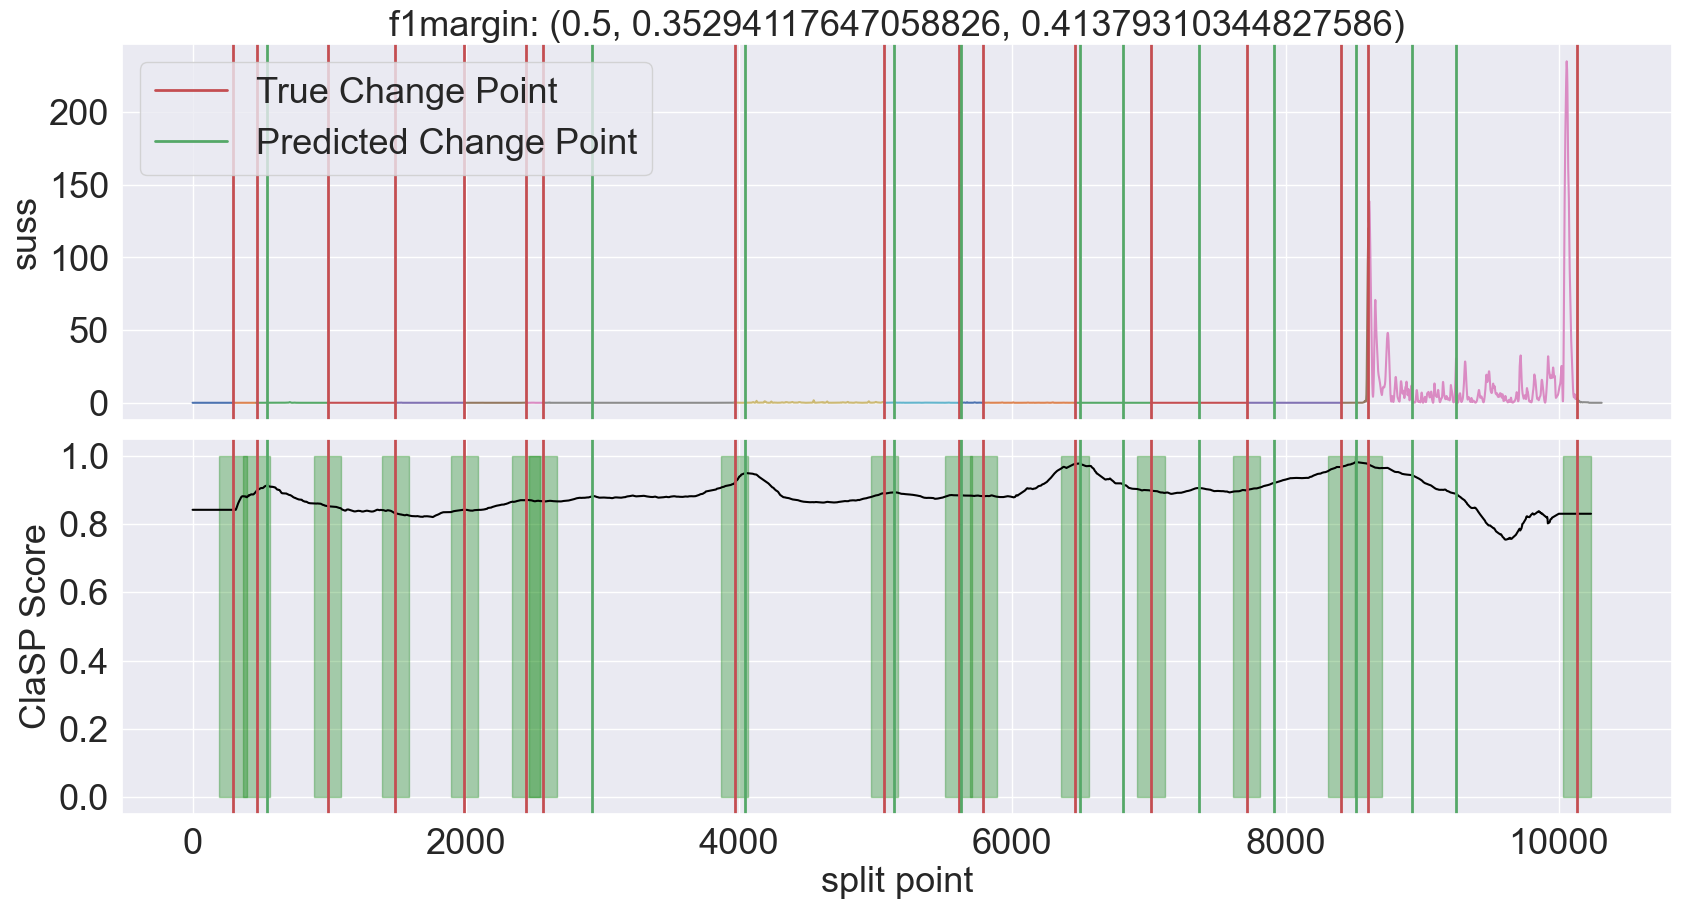

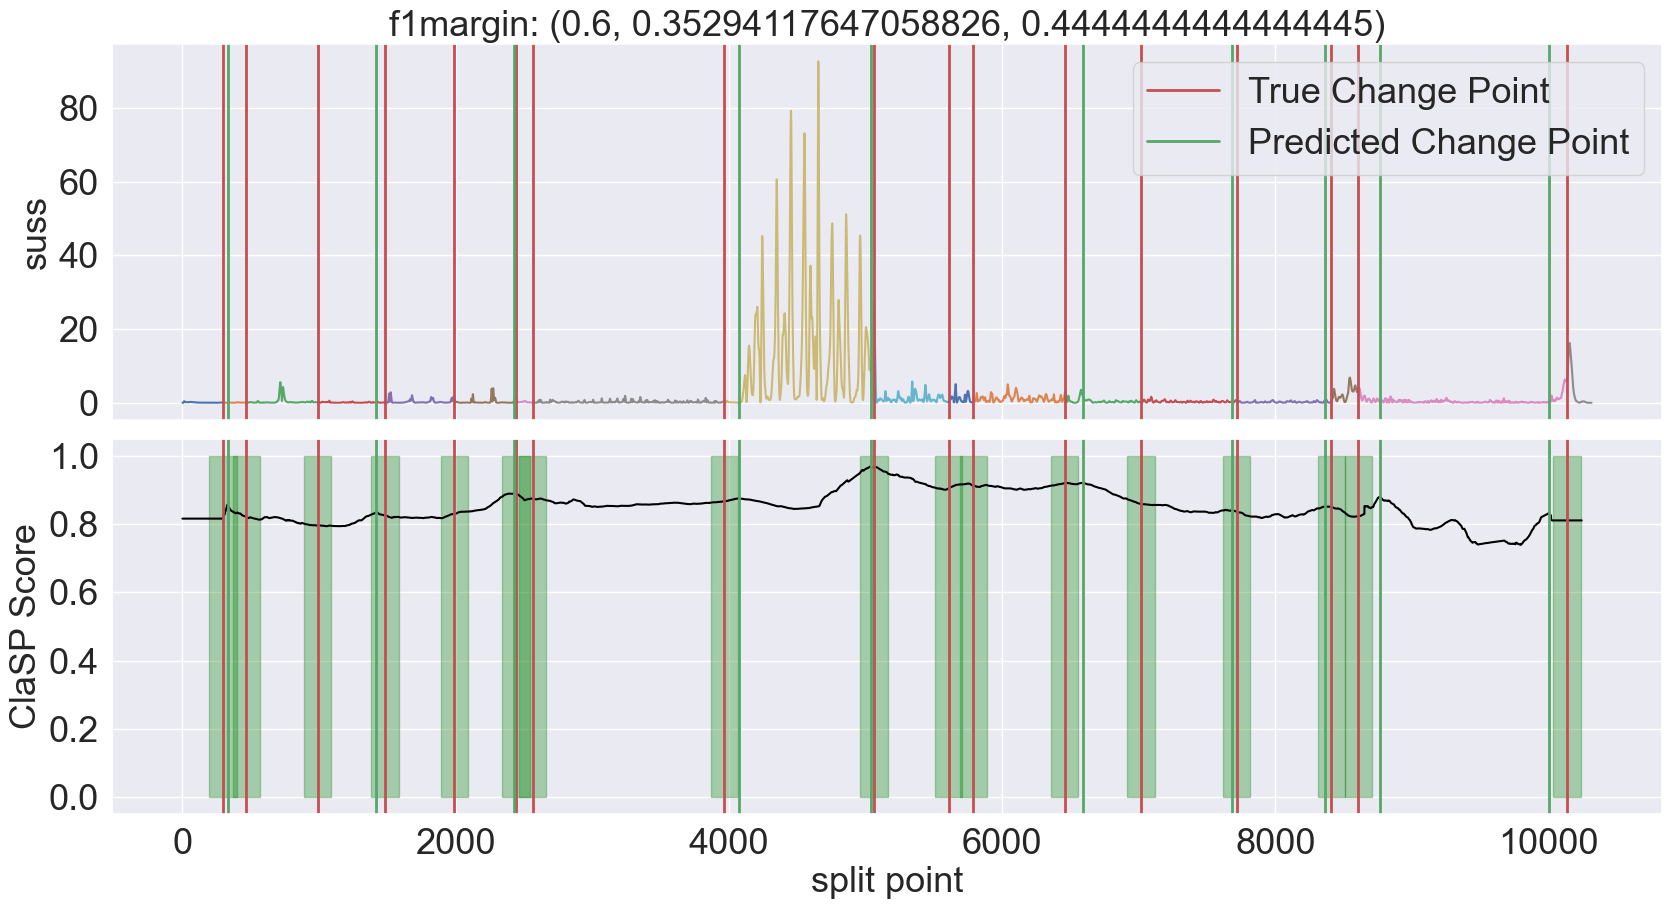

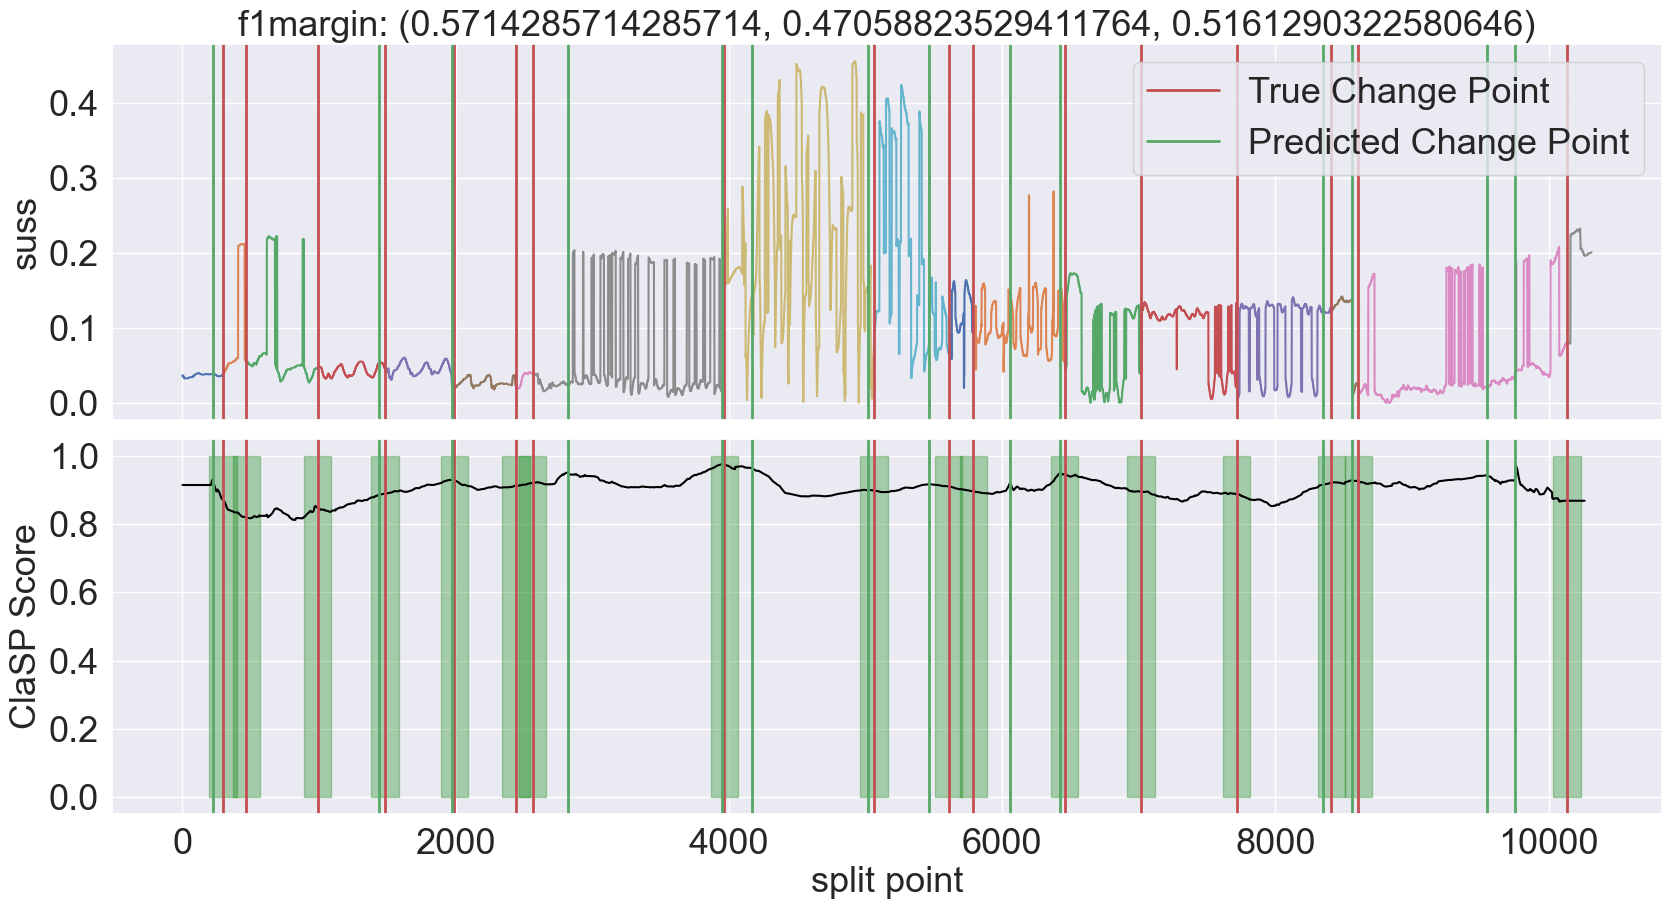

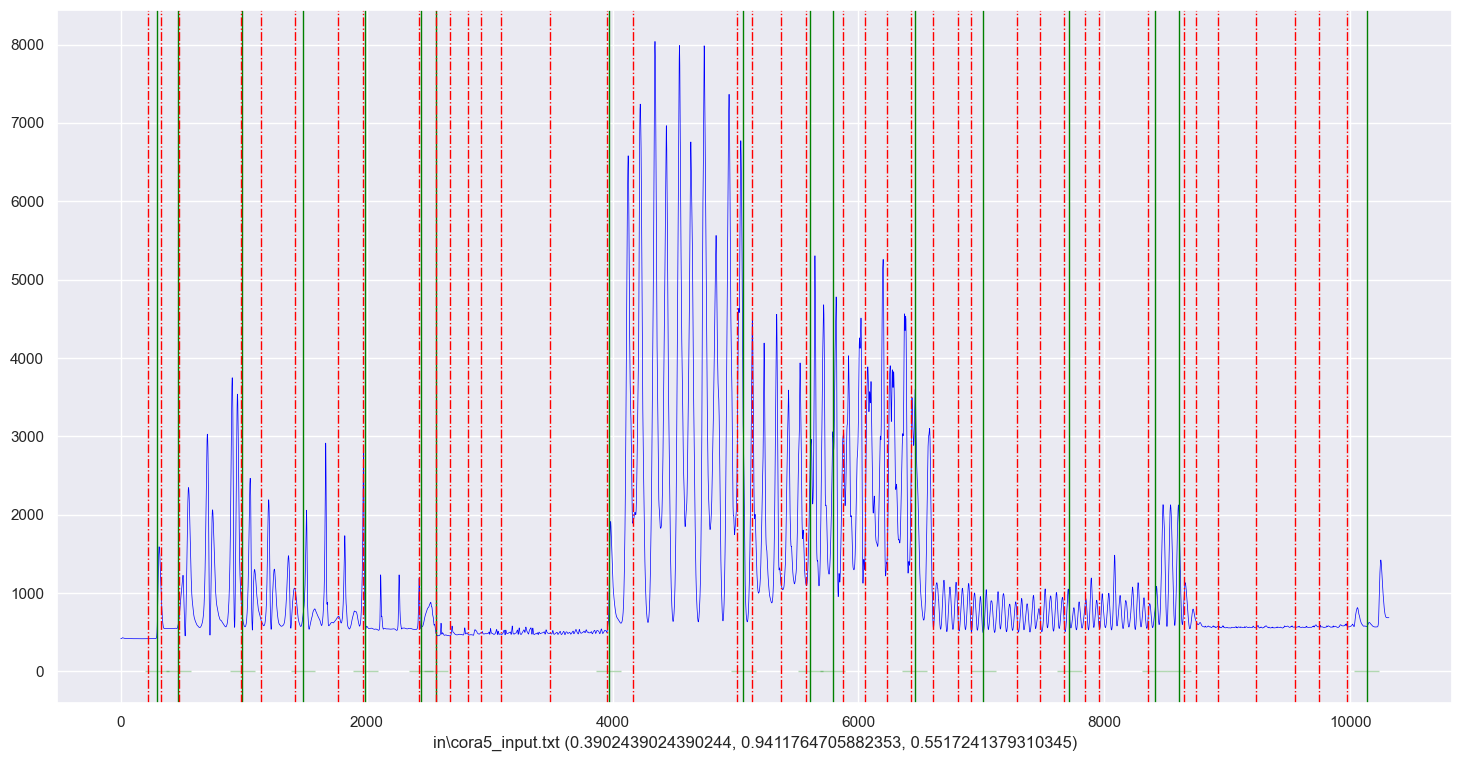

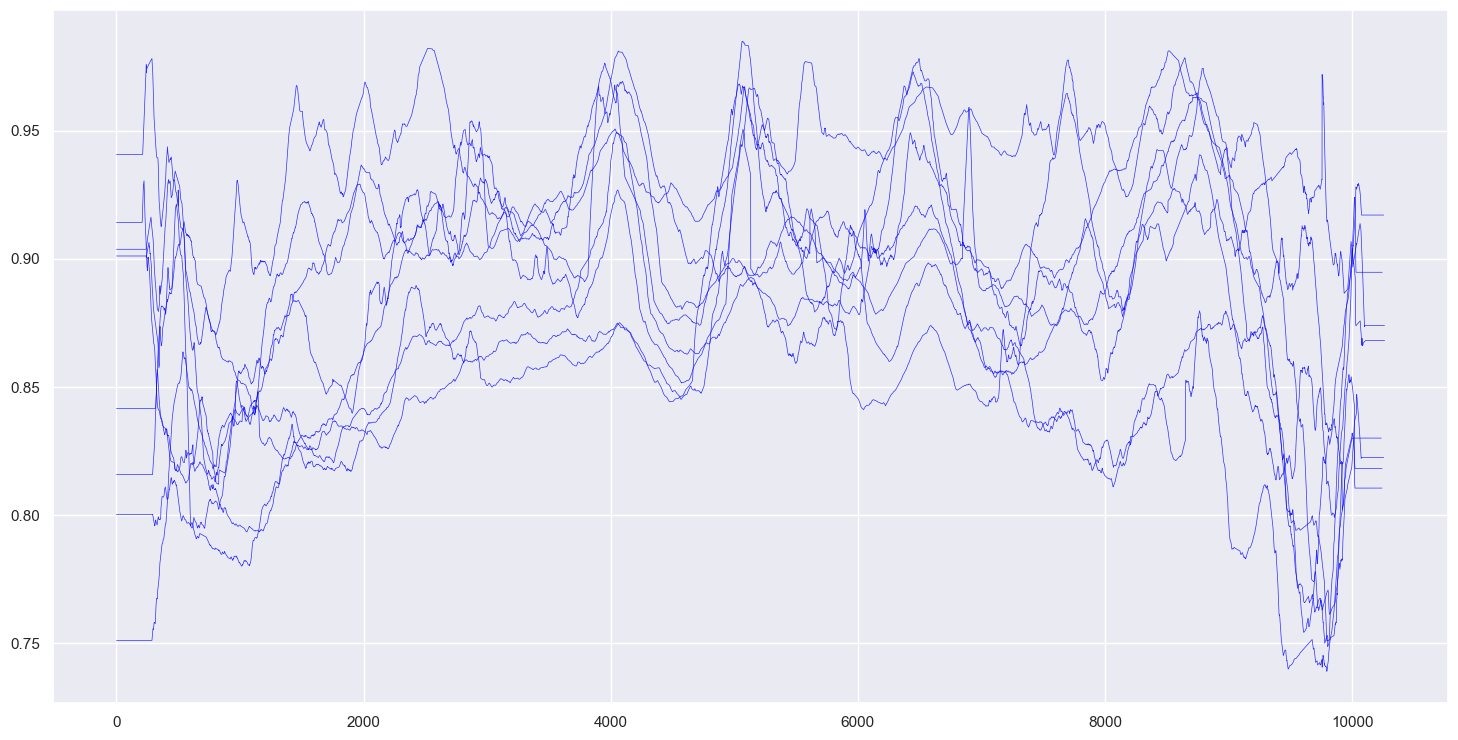

In [51]:
# CLASP without knowing cp
for i in range(2,3):#len(timeseries)):
    df=ReadAndPreProcess(timeseries[i])
    gt=LoadingGroundTruth(df,groundtruth[i])
    cp,eachcp,clasp=GetClasp(df,gt,0, window_size="suss",distance="euclidean_distance",excl_radius=4, n_jobs=8)
    Plotclasp(clasp,gt,100,eachcp)
    cp=delnear(cp,100)
    PlotResult(df,gt,cp,timeseries[i],100,clasp)
    Evaluate("CLASP",groundtruth[i],gt,timeseries[i],cp,df,100)

# CLASP without knowing cp
for i in range(2,3):#len(timeseries)):
    df=ReadAndPreProcess(timeseries[i])
    gt=LoadingGroundTruth(df,groundtruth[i])
    cp,eachcp,clasp=GetClasp(df,gt,0, window_size="fft",distance="euclidean_distance",excl_radius=4, n_jobs=8)
    Plotclasp(clasp,gt,100,eachcp)
    PlotResult(df,gt,cp,timeseries[i],100)
    Evaluate("CLASP",groundtruth[i],gt,timeseries[i],cp,df,100)

# CLASP without knowing cp
for i in range(0,1):#len(timeseries)):
    df=ReadAndPreProcess(timeseries[i])
    gt=LoadingGroundTruth(df,groundtruth[i])
    cp,eachcp,clasp=GetClasp(df,gt,0,n_segments=17, validation=None, window_size="fft",distance="euclidean_distance")
    Plotclasp(clasp,gt,100,eachcp)
    Evaluate("CLASP",groundtruth[i],gt,timeseries[i],cp,df,100)

# CLASP without knowing cp
for i in range(0,1):#len(timeseries)):
    df=ReadAndPreProcess(timeseries[i])
    gt=LoadingGroundTruth(df,groundtruth[i])
    cp,eachcp,clasp=GetClasp(df,gt,0,n_segments=17, validation=None, window_size="acf",distance="euclidean_distance")
    Plotclasp(clasp,gt,100,eachcp)
    Evaluate("CLASP",groundtruth[i],gt,timeseries[i],cp,df,100)

#clasp solo su densità per tutti i 3 casi


for i in range(0,len(timeseries)):
    for j in range(0,3):
        df=ReadAndPreProcess(timeseries[i])
        gt=LoadingGroundTruth(df,groundtruth[i])
        if j == 0:
            cp,eachcp,clasp=GetClasp(df,gt,0, window_size="suss",distance="euclidean_distance")
        elif j == 1:
            cp,eachcp,clasp=GetClasp(df,gt,0, window_size="fft",distance="euclidean_distance")
        else:
            cp,eachcp,clasp=GetClasp(df,gt,0, window_size="acf",distance="euclidean_distance")
        print("j"+str(j))
        Plotclasp(clasp,gt,100,eachcp,timeseries[i],j)
        Evaluate("CLASP",groundtruth[i],gt,timeseries[i],cp,df,100)